In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib
from analyze import * # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import norm
import shutil

%matplotlib inline

In [57]:
run = 18930
s = SPE('/project/lgrandi/xenon1t/spe_acceptance/data/run_%05d.h5' % run)


res, res_errs = s.residual(6, 'amplitude')
acc, errs = s.acceptance(6, 'amplitude')
bins = s.data['bin_centers']



In [58]:
errs[0,:,:] = acc - errs[0,:,:]
errs[1,:,:] = errs[1:,:] - acc 


In [59]:
thresholds = get_thresholds(find_regular_run(18910))

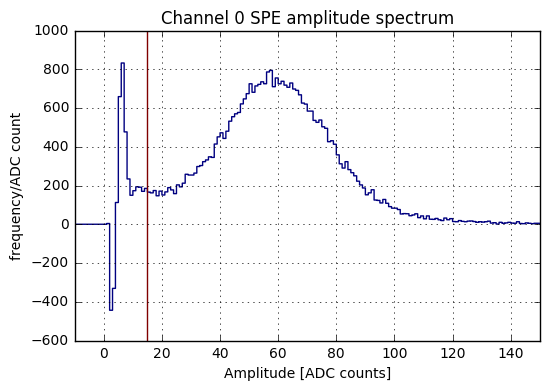

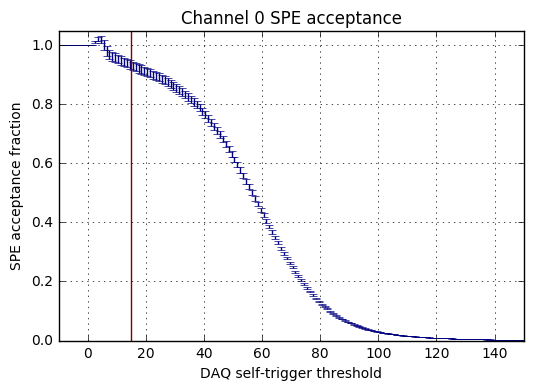

In [65]:
ch = 0

plt.plot(bins, res[ch], color='navy', drawstyle='steps-mid' )
plt.xlim(-10, 150)
plt.xlabel('Amplitude [ADC counts]')
plt.ylabel('frequency/ADC count')
plt.axvline(thresholds[ch], color='maroon', label='hardware threshold')
plt.title('Channel %d SPE amplitude spectrum' % ch)
plt.grid()
plt.savefig('ch0_spe.pdf')
plt.show()


plt.errorbar(bins, acc[ch], yerr=(errs[0, ch], errs[1,ch]), linestyle='None', color='navy')
plt.xlim(-10, 150)
plt.ylim(0, 1.05)
plt.xlabel('DAQ self-trigger threshold')
plt.ylabel('SPE acceptance fraction')
plt.axvline(thresholds[ch], color='maroon', label='hardware threshold')
plt.title('Channel %d SPE acceptance' % ch)
plt.savefig('ch0_speacc.pdf')
plt.grid()
plt.show()

In [66]:
acc, stat, sys = acceptance_3runs(18928, 18929, 18930, thresholds)

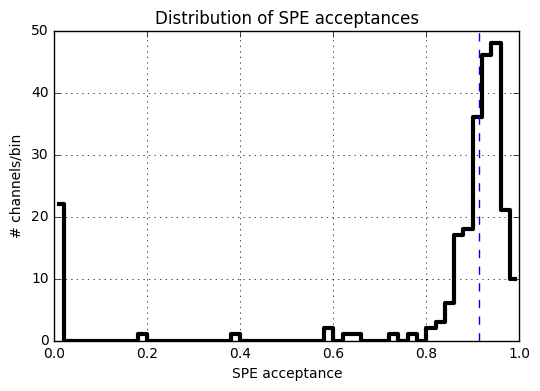

In [74]:
hist, bins = np.histogram(acc, bins=50, range=(0, 1))
bins = 0.5*(bins[1:]+bins[:-1])


plt.plot(bins, hist, color='black', drawstyle='steps-mid', linewidth=3)
mean = np.mean(acc[np.where(acc > 0.05)])
plt.axvline(mean, linestyle='dashed', color='blue')
plt.xlabel('SPE acceptance')
plt.ylabel('# channels/bin')
plt.title('Distribution of SPE acceptances')
plt.grid()
plt.savefig('speacc_dist.pdf')
plt.show()

In [ ]:
plt.figure(figsize=(9,6))
plt.errorbar(np.arange(248), acc, yerr=stat, linestyle='None')
plt.grid()
plt.ylim(0.5, 1.2)
plt.show()

In [ ]:
with open('current_acceptance.csv', 'w') as f:
    for ch, acc in enumerate(acc):
        f.write("%s,%s\n" % (ch,acc))
    

In [ ]:
data_dir_base = '/project/lgrandi/xenon1t/spe_acceptance/data'

def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

runlists = []
for runlist in os.listdir('runlists'):
    if all_data_exists(file_to_list(runlist)):
        runlists.append(runlist)

In [ ]:
bottom_runs = []
acceptance = []
errs = []

for runlist in tqdm(runlists):
    l = file_to_list(runlist)
    
    if l[0] < 6846:
        continue
        #thresholds = np.load('selftrigger_thresholds_SR1_before6846.npz')['thresholds']
    
    elif 6846 < l[0] < 18000:
        thresholds = np.load('selftrigger_thresholds_SR1_after6846.npz')['thresholds']
    elif 18000 < l[0]:
        thresholds = get_thresholds(find_regular_run(l[0]))
        
    acc, stat, sys = acceptance_3runs(l[0], l[1], l[2], thresholds)
    
    bottom_runs.append(l[0])
    acceptance.append(acc)
    errs.append(stat)

    
acceptance = np.array(acceptance)
bottom_runs = np.array(bottom_runs)
errs = np.array(errs)

In [ ]:
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import datetime

months = mdates.MonthLocator()
years = mdates.YearLocator()
datetimefmt = mdates.DateFormatter("%d-%m")


dates = [get_run_time(run) for run in bottom_runs]
today = datetime.date.today()


def plot_channel(ch):
    f, ax = plt.subplots(figsize=(8,5))
    ax.fmt_xdata = mdates.DateFormatter('%d-%m')
    ax.errorbar(dates, acceptance[:, ch], yerr=[errs[:,0,ch], errs[:,1,ch]], linestyle='None', 
                color='navy')
    ax.xaxis.set_major_formatter(datetimefmt)
    ax.xaxis.set_major_locator(months)
    plt.xlabel('Date')
    plt.ylabel('SPE Acceptance')
    plt.title('Channel %d' %ch)
    f.autofmt_xdate()
    plt.grid()
    plt.ylim(-0.1, 1.1)
    plt.xlim(datetime.date(year=2017, month=10, day=1), datetime.date(year=2018, month=5, day=1) )
    plt.savefig('plots/ch%d.png' % ch)
    plt.show()

In [ ]:
table = "^Channel^Acceptance^\n"

for ch in [12, 34, 86, 134, 148, 190, 213]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(acceptance[indices, ch])
    table += "|%d|%0.2f|\n" % (ch, a)

table2 = "^Channel^Acceptance^Uncertainty^\n"
for ch in [27, 73, 87, 167, 203]:
    plot_channel(ch)
    indices = [dates.index(date) for date in sorted(dates)[-2:]]
    a = np.mean(acceptance[indices, ch])
    table2 += "|%d|%0.2f|\n" % (ch, a)

In [ ]:
print(table)

print(table2)